In [1]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -------- ------------------------------- 2.9/13.3 MB 12.9 MB/s eta 0:00:01
   ------------------- -------------------- 6.6/13.3 MB 15.5 MB/s eta 0:00:01
   ------------------------------------ --- 12.3/13.3 MB 19.8 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 19.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 16.8 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


23:48:33 - cmdstanpy - INFO - Chain [1] start processing
23:48:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Kunal\AppData\Local\Temp\ipykernel_11944\1317370367.py:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


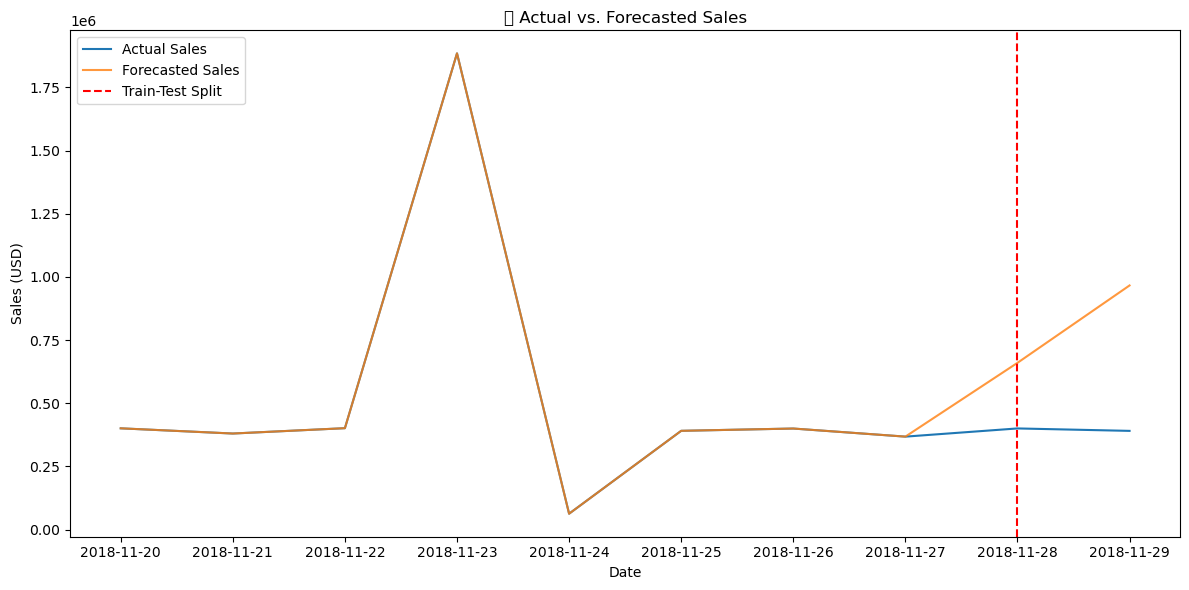

📊 MAE: 417476.39
📊 RMSE: 446346.29
📊 MAPE: 106.01%


In [2]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load pre-processed time series data
df = pd.read_csv("processed_time_series_sales.csv")
df['date'] = pd.to_datetime(df['date'])

# Step 2: Rename columns as required by Prophet
df_prophet = df[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

# Step 3: Split into train (80%) and test (20%)
split_point = int(len(df_prophet) * 0.8)
train = df_prophet[:split_point]
test = df_prophet[split_point:]

# Step 4: Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(train)

# Step 5: Create future dataframe for next 180 days (~6 months)
future = model.make_future_dataframe(periods=len(test), freq='D')

# Step 6: Make predictions
forecast = model.predict(future)

# Step 7: Plot forecast vs. actual
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual Sales')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Sales', alpha=0.8)
plt.axvline(x=df_prophet['ds'][split_point], color='r', linestyle='--', label='Train-Test Split')
plt.title("📈 Actual vs. Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Sales (USD)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Evaluate accuracy on the test set
# Merge forecast with test data for comparison
compare_df = forecast[['ds', 'yhat']].set_index('ds').join(test.set_index('ds'))
compare_df.dropna(inplace=True)

# Accuracy metrics
mae = mean_absolute_error(compare_df['y'], compare_df['yhat'])
rmse = np.sqrt(mean_squared_error(compare_df['y'], compare_df['yhat']))
mape = np.mean(np.abs((compare_df['y'] - compare_df['yhat']) / compare_df['y'])) * 100

print(f"📊 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAPE: {mape:.2f}%")

# Step 9: Save forecast
forecast.to_csv("forecasted_sales_6_months.csv", index=False)
